<a href="https://colab.research.google.com/github/accarter/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


# Library Imports, Reading in the Dataset, and Data Cleaning

In [0]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

column_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']

house = pd.read_csv(url, header=None, names=column_headers, na_values="?")
house.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [3]:
house = house.replace({
    'n': 0,
    'y': 1
})

house.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


# Numeric Representation of Confidence Intervals

In [4]:
def conf_int1(data, confidence=0.95):
  '''
  Calculate a confidence interval around a sample mean for the given data.
  Returns: mean, lower bound, upper bound.

  Implementation: first technique outlined in lecture without using
  built-in stats.t.interval method.
  '''
  sample = np.array(data)
  xbar = np.mean(sample)
  n = len(sample)
  stderr = np.std(sample, ddof=1) / np.sqrt(n)
  margin = stderr * stats.t.ppf((1 + confidence) / 2, n - 1)
  return (xbar, xbar - margin, xbar + margin)

def conf_int2(data, confidence=0.95):
  '''
  Calculate a confidence interval around a sample mean for the given data.
  Returns: mean, lower bound, upper bound

  Implemenation: second technique outlined in lecture including the
  use of stats.t.interval method.
  '''
  xbar = np.mean(data)
  n = len(data)
  dof = n - 1
  stderr = np.std(data, ddof=1) / n ** 0.5
  lower, upper = stats.t.interval(confidence, dof, loc=xbar, scale=stderr)
  return (xbar, lower, upper)

def support_bill_ci(sample, bill, confidence=0.95):
  '''
  Calculates a confidence interval of the percentage for which the members
  of the given sample are in favor of the specified bill.
  '''
  # return conf_int1(sample[bill].dropna(), confidence)
  return conf_int2(sample[bill].dropna(), confidence)

def gen_conf_int_df(names, issues, house):
  '''
  Produces a DataFrame containing the confidence intervals for the percentage
  of members from each of the specified party names in favor of each of the 
  given issues.
  '''
  bills = []
  parties = []
  means = []
  upper_bounds = []
  lower_bounds = []

  for bill in issues:
    for party in names:
      parties.append(party)
      bills.append(bill)
      sample = house[house['party'] == party]
      mean, upper, lower = support_bill_ci(sample, bill)
      means.append(mean)
      upper_bounds.append(upper)
      lower_bounds.append(lower)

  return pd.DataFrame({
      'bill': bills,
      'party': parties,
      'mean': means,
      'upper_bound': upper_bounds,
      'lower_bound': lower_bounds
  })

house_conf_ints = gen_conf_int_df(house['party'].unique(), column_headers[1:], house)
house_conf_ints

,bill,party,mean,upper_bound,lower_bound
0,handicapped-infants,republican,0.187879,0.127652,0.248106
1,handicapped-infants,democrat,0.604651,0.544593,0.664710
2,water-project,republican,0.506757,0.425266,0.588248
3,water-project,democrat,0.502092,0.438245,0.565939
4,budget,republican,0.134146,0.081435,0.186857
5,budget,democrat,0.888462,0.849944,0.926980
6,physician-fee-freeze,republican,0.987879,0.971007,1.004751
7,physician-fee-freeze,democrat,0.054054,0.026332,0.081776
8,el-salvador-aid,republican,0.951515,0.918398,0.984632
9,el-salvador-aid,democrat,0.215686,0.164863,0.266509


**Interpretation**

Each confidence interval computed above describes a potential range of values with a lower and upper bound within which we are 95% confident the actual population mean for each party exists.

For example, the first row can be interpreted as we are 95% confident that the percentage of Republicans in support of the handicapped infants bill is within 12.8% to 24.8% or, stated more succinctly, the number of Republicans in support of the handicapped infants bill is 18.8% ± 6.0% with a 95% degree of certainty.

# Graphical Representaion of Confidence Intervals

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


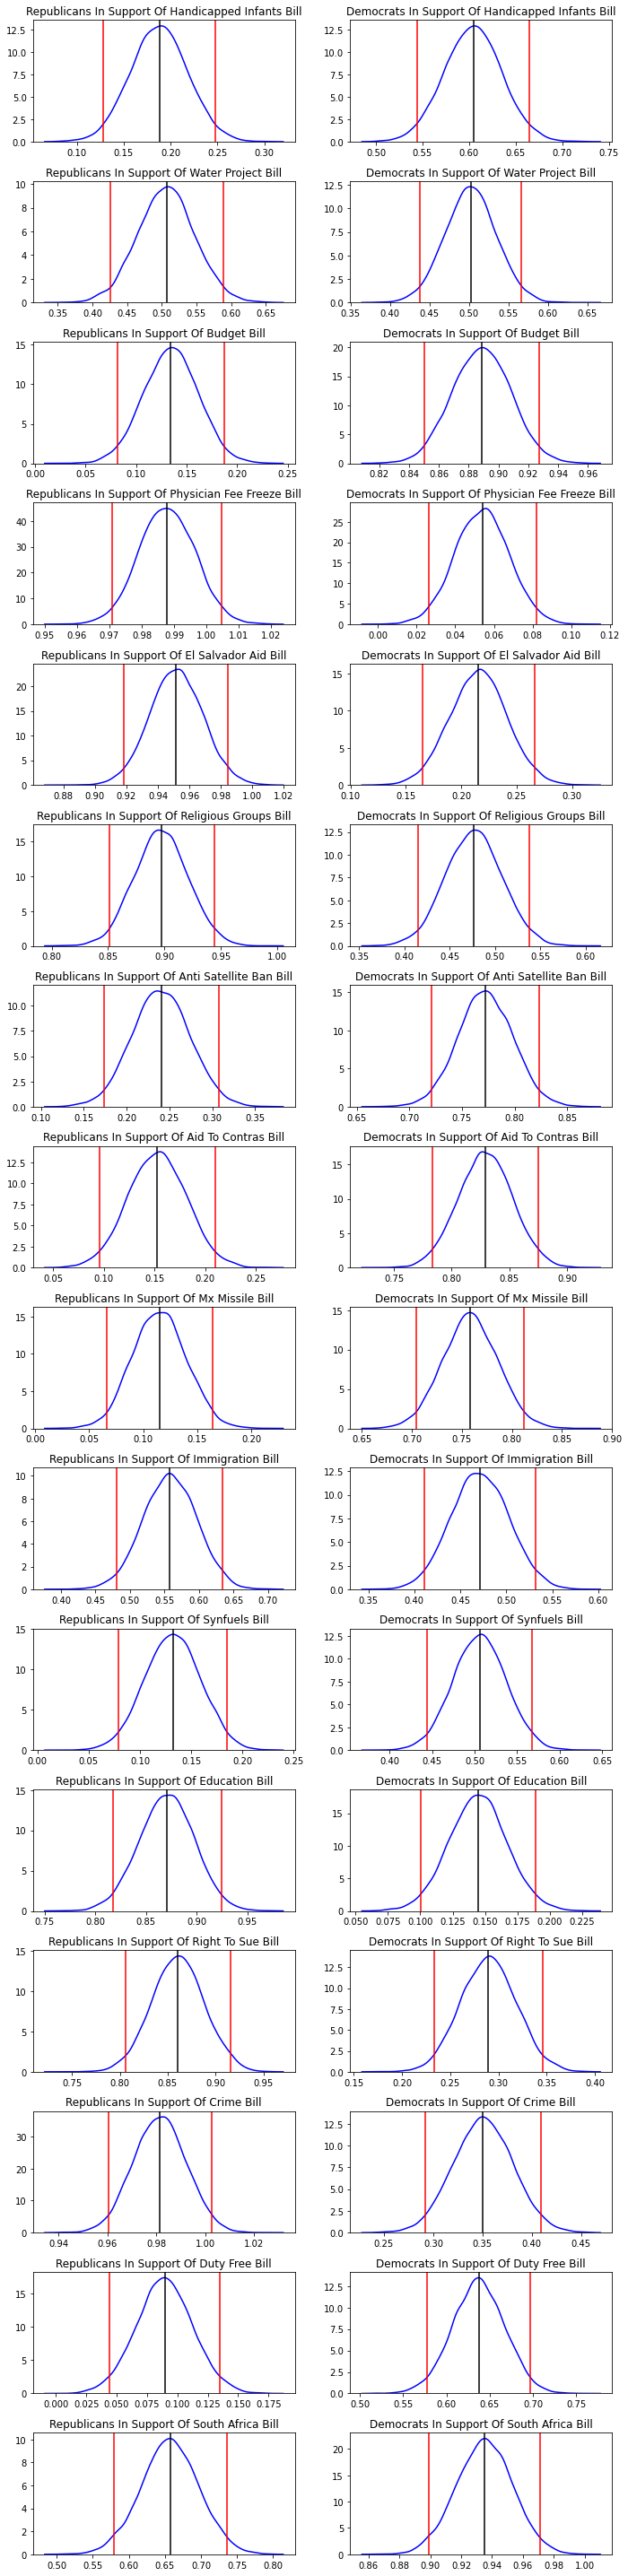

In [22]:
def display_conf_int(df, bill, x, y, title, axes):
  '''
  Display the confidence interval for the percentage of supporters
  on the specified bill.
  '''
  mean, upper, lower = support_bill_ci(df, bill)
  sample = np.array(df[bill].dropna())
  # standard error of the sample is the standard deviation for the
  # distribution of all possible sample means to be drawn from the population
  std_err = np.std(sample, ddof=1) / len(sample) ** 0.5
  sample_means = np.random.normal(mean, std_err, 10000)
  ax = sns.kdeplot(sample_means, color="b", ax=axes[x, y])
  ax.set(title=title)
  ax.axvline(x=lower, color='red')
  ax.axvline(x=upper, color='red')
  ax.axvline(x=mean, color='black')

def display_conf_ints(df):
  '''
  Display all confidence intervals for the Congressional House Votes dataframe.
  '''
  n_parties = house['party'].nunique()
  n_bills = len(column_headers) - 1
  n_plots = len(house_conf_ints)

  fig, axes = plt.subplots(n_bills, n_parties, figsize=(10, 40))

  i = 0
  for party in house['party'].unique():
    for bill in column_headers[1:]:
      sample = house[house['party'] == party]
      title = '{}s in support of {} Bill'.format(party, bill.replace('-', ' ')).title()
      display_conf_int(house[house['party'] == party],
                       bill,
                       i % n_bills, 
                       i // n_bills, 
                       title,
                       axes)
      i += 1
  plt.tight_layout()

display_conf_ints(house)

## Chi Squared Test - Tips (Sex vs. Day of Week)

In [0]:
tips = sns.load_dataset('tips')
tips.head()

In [0]:
tips.describe(exclude='number')

Function definitions for testing other possible crosstabs

In [0]:
def gen_expected(arr1, arr2):
  '''
  Calculate the expected distribution for the two arrays.
  '''
  # calculate the expected distribution using row and column totals
  xtab = pd.crosstab(arr1, arr2, margins=True)
  n_rows, n_cols = xtab.shape
  y, x = n_rows-1, n_cols-1
  row_sums = xtab.iloc[:y, x].values
  col_sums = xtab.iloc[y, :x].values
  total = xtab.loc['All', 'All']
  return [[row*col/total for col in col_sums] for row in row_sums]

def chi_sq(c1, c2, df):
  '''
  Calculate the chi squared statistic for the given DataFrame for the
  two specified categories.

  Encapsulates the logic used to calculate a chi squared value covered
  in lecture.
  '''
  # bind 2-dimensional np.Array of actual values to observed
  observed = pd.crosstab(df[c1], df[c2]).values
  expected = gen_expected(df[c1], df[c2])

  # calculate the chi squared value as the sum of ratios between the square 
  # of the differences between the observed and expected values to the expected value
  return np.sum(((observed - expected ) ** 2 / expected))


chi_sq('day', 'sex', tips)

Walk-through of the steps performed of calculating a chi-squared value

In [0]:
# roughly twice as many men as women, so if the day of the week was not a 
# factor then for each day of the week you would expect twice as many male 
# customers than female customers
tips['sex'].value_counts().sort_index()

In [0]:
# Saturday appears to have the most customers, so if sex is not a factor then
# you would expect you would expect an equal amount of change in the number
# of customers that show up for either gender
tips['day'].value_counts().sort_index()

In [0]:
# create of crosstab for sex and the day of the week
day_by_sex_tab = pd.crosstab(tips['day'], tips['sex'], margins=True)
day_by_sex_tab

In [0]:
observed = pd.crosstab(tips['day'], tips['sex']).values
observed

In [0]:
day_by_sex_tab

In [0]:
# row sums
row_sums = day_by_sex_tab.iloc[:4, 2].values
row_sums

In [0]:
# col sums
col_sums = day_by_sex_tab.iloc[4, :2].values
col_sums

In [0]:
total = day_by_sex_tab.loc['All', 'All']
total

In [0]:
# what are the expected values to be compared against the observed values
expected = [[row*col/total for col in col_sums] for row in row_sums]
expected

In [0]:
# expectation if data is evenly distributed (null hypothesis)
pd.DataFrame(expected)

In [0]:
# actual distribution
day_by_sex_tab

In [0]:
chi_square = np.sum(((observed - expected ) ** 2 / expected))
chi_square

In [0]:
# chi2_contingency method provided with scipy.stats package
stat, pvalue, dof, expected = stats.chi2_contingency(observed)
stat

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

# Summary of Findings Regarding House Votes

Here are a few of the findings that can be reported on from the results shown above.

In [0]:
house_conf_ints[house_conf_ints['bill'] == 'water-project']

According to the results for the water project bill, party lines can not be used as a way of predicting whether or not someone supports the bill.  For either party, we can say with 95% confidence that the percentage of individuals in support of the bill is the same - around 50% with anywhere from a 6-8% margin of error depending on the party.

In [0]:
house_conf_ints[house_conf_ints['bill'] == 'crime']

However, the results for the crime bill are clearly different.  There is an obvious gap between the amount of support for the crime bill among republicans than there is from democrats.  Republicans are largely in favor of the bill, with support being anywhere from 96% to 100%, while Democrats are unsupportive of the bill, with a relatively small 35% in support.

# Summary of Findings Regarding Tips: Sex vs. Day of Week

In [0]:
print('stat: ', stat)
print('pvalue: ', pvalue)
print('dof: ', dof)
print('expected: ')
pd.DataFrame(expected)

An interpretation of the results may best be expressed with regard to the null hypothesis, which is that if the sex of a customer had no effect on whether or not he or she was more or less likely to visit the restaurant because of the day of the week, then the amount of day-to-day fluctuation in the numbers of customers would be the same for either sex.

In this case, we reject the null hypothesis, since the p-value is well below 0.05.  The results of the chi squared test indicate that there is not an even distribution among the customers visiting a restaurant for each day of the week based on sex.  In other words, if there was an even distribution, the results from the sample taken would be exceptionally rare.

Referring back to the null hypothesis - because there are more males than females, we would expect more male customers than females customers for any given day of the week, but as shown in the bar plot below this is not the case, since female customers are nearly equal or greater in number than male customers on Thursdays and Fridays.

This implies, that a change in the day of the week does not necessarily imply a similar change in the number of customers for each sex.

In [0]:
pd.crosstab(tips['day'], tips['sex']).plot(kind='bar');

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)